In [1]:
import numpy as np
from gridworld import Gridworld
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
rewards = np.zeros((3, 4), dtype=int)
rewards[0, 3] = 1
rewards[1, 3] = -1

state_types = np.zeros((3, 4), dtype=int)
state_types[0, 3] = 1
state_types[1, 3] = 1
state_types[1, 1] = 2

q_table = np.zeros((3, 4, 4))

slip = {
    'left': 0.2,
    'right': 0.2,
    'backward': 0
}
gw = Gridworld(state_types, rewards, q_table,
               slip=slip, gamma=0.9, step_reward=-0.02)
print(state_types)
print(rewards)

[[0 0 0 1]
 [0 2 0 1]
 [0 0 0 0]]
[[ 0  0  0  1]
 [ 0  0  0 -1]
 [ 0  0  0  0]]


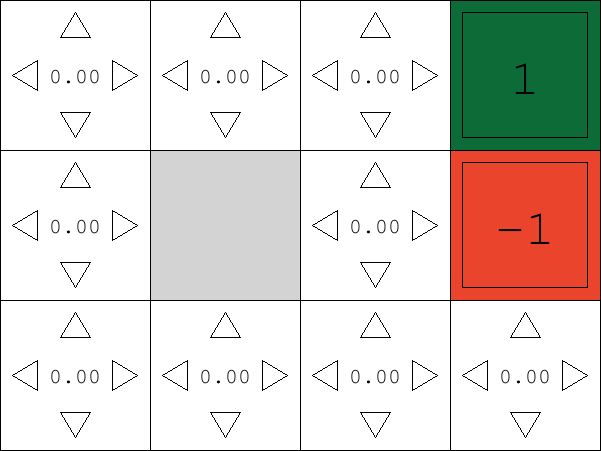

In [3]:
display.display(gw.render(policy=True))

In [4]:
gw.solve()

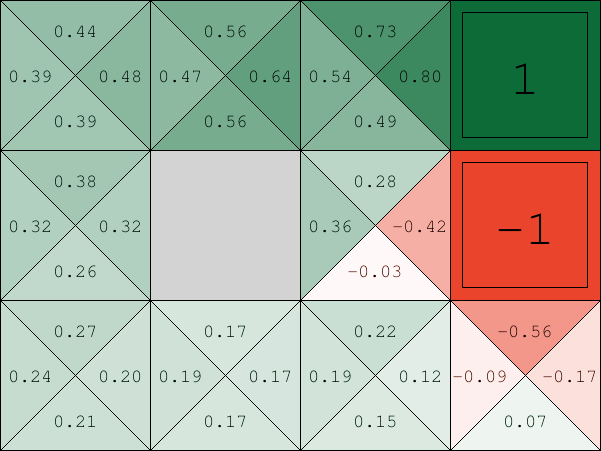

In [5]:
display.display(gw.render())

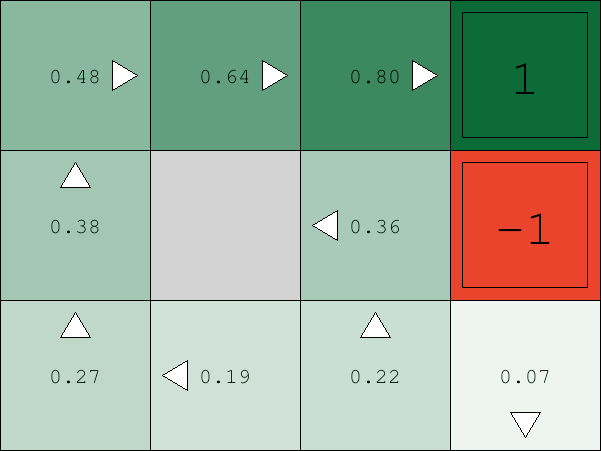

In [6]:
display.display(gw.render(policy=True))

In [7]:
rewards = np.zeros((4, 4), dtype=int)
rewards[3, 3] = 1

state_types = np.zeros((4, 4), dtype=int)
state_types[3, 3] = 1
state_types[3, 0] = 1
state_types[1, 1] = 1
state_types[1, 3] = 1
state_types[2, 3] = 1

q_table = np.zeros((4, 4, 4))

slip = {
    'left': 1/3,
    'right': 1/3,
    'backward': 0
}
gw = Gridworld(state_types, rewards, q_table,
               slip=slip, gamma=0.98, step_reward=0)
print(state_types)
print(rewards)

[[0 0 0 0]
 [0 1 0 1]
 [0 0 0 1]
 [1 0 0 1]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]]


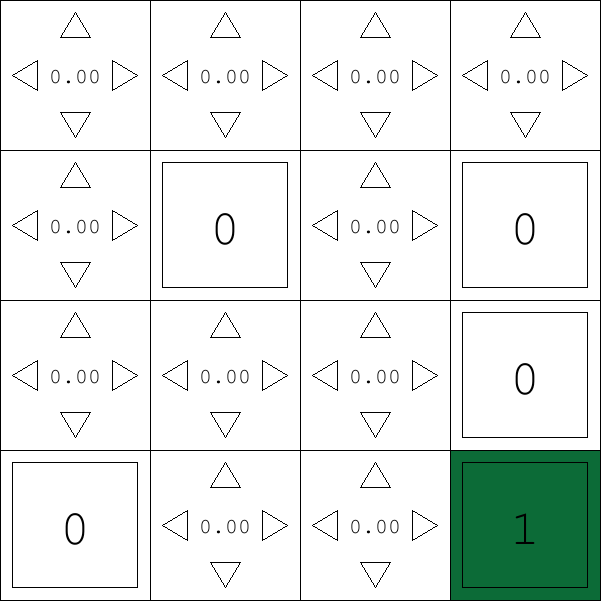

In [8]:
display.display(gw.render(policy=True))

In [9]:
# hyperparameters
N_EPISODES = 2000
MAX_STEPS_PER_EPISODE = 100

ALPHA = 0.1  # learning rate
GAMMA = 0.98  # discount rate

EPSILON = 0.1  # exploration rate

LOG_RATE = N_EPISODES / 10

KeyboardInterrupt: 

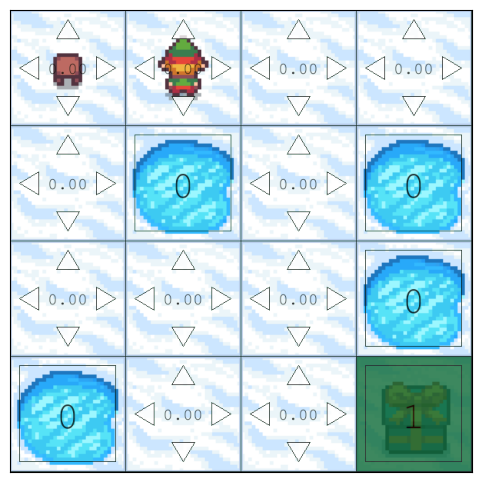

In [10]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')  # creating the environment

plt.figure(figsize=(6, 6))
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render(), extent=[-8,8,-8,8])
img2 = plt.imshow(np.asarray(gw.render(policy=True)), extent=[-8,8,-8,8], alpha=0.8)
for episode in range(N_EPISODES):
    state, _ = env.reset()
    done = False

    for step in range(MAX_STEPS_PER_EPISODE):
        j = state % 4
        i = (state - j) // 4
        # epsilon-greedy action selection
        if np.random.rand() > EPSILON:
            action = np.argmax(q_table[i, j, :])
            action = {
                0: 3,
                1: 2,
                2: 1,
                3: 0
            }[action]
        else:
            action = env.action_space.sample()

        new_state, reward, done, truncated, info = env.step(action)
        j_new = new_state % 4
        i_new = (new_state - j_new) // 4
        action = {
            0: 3,
            1: 2,
            2: 1,
            3: 0
        }[action]

        # updating q-table
        q_table[i, j, action] = q_table[i, j, action] * (1 - ALPHA) + \
            ALPHA * (reward + GAMMA * np.max(q_table[i_new, j_new, :]))

        state = new_state
        img.set_data(env.render())
        img2.set_data(gw.render(policy=True))
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if done:
            time.sleep(1)
            break


In [11]:
print(q_table)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


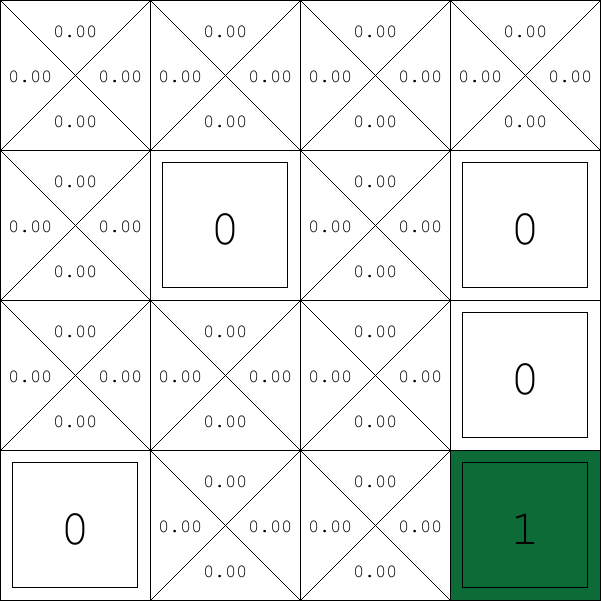

In [12]:
gw.render()

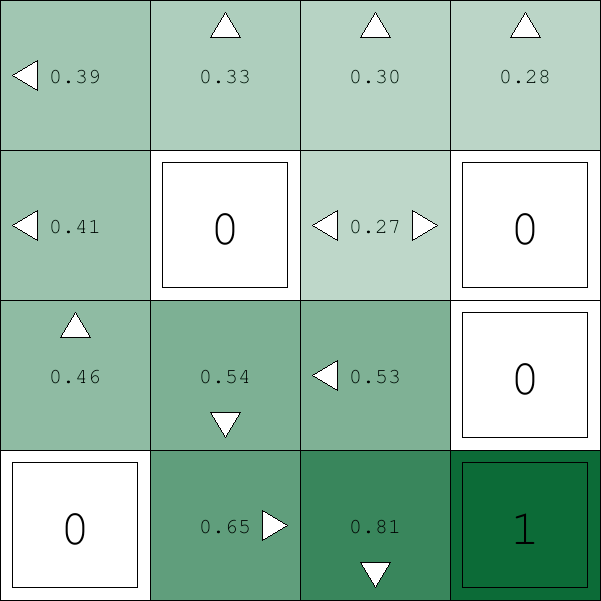

In [15]:
gw.solve()
gw.render(policy=True)